# MACHINE LEARNING  (by Prof.Krystyn Gutu)
# PROJECT 2: Anomaly Detection Task
## CRN:-74016 ; FALL 2023
## Submitted by: Piyush Gupta

### Import Necessary Libraries

**1. Pandas:** A fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language. It provides data structures like DataFrames and Series for handling and analyzing structured data.<br>
**2. Matplotlib:** A plotting library for the Python programming language and its numerical mathematics extension, NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK.<br>
**3. KMeans:** An algorithm from the sklearn.cluster module that partitions data into k distinct clusters based on distance to the centroid of a cluster. It's an unsupervised learning method used for clustering purposes.<br>
**4. StandardScaler:** A method from the sklearn.preprocessing module that standardizes features by removing the mean and scaling to unit variance. This is often a necessary step in data preprocessing to ensure that all features are on the same scale.<br>
**5. LabelEncoder:** A utility from the sklearn.preprocessing module that is used to transform non-numerical labels to numerical labels (and vice-versa). It's useful when dealing with categorical variables in datasets.<br>
**6. Numpy:** A library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.<br>
**7. PCA (Principal Component Analysis):** A method from the sklearn.decomposition module used for dimensionality reduction. PCA transforms the original variables into a new set of variables (the principal components) which are orthogonal (uncorrelated), and which reflect the maximum variance in the data.<br>
**8. EllipticEnvelope:** An algorithm from the sklearn.covariance module to detect outliers in a Gaussian distributed dataset. It fits an ellipse to the central data points, classifying as outliers the observations which are outside of the ellipse.<br>
**9. IsolationForest:** An algorithm from the sklearn.ensemble module used for outlier detection. It isolates anomalies by randomly selecting a feature and randomly selecting a split value between the maximum and minimum values of the selected feature. This random partitioning produces shorter paths for anomalies, allowing them to be easily detected.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from kneed import KneeLocator

### Loading the dataset into pandas dataframe

In [2]:
data = pd.read_csv('temperature_device_failure.csv')

**1. Checking the shape of the dataset - <br>The shape attribute of a DataFrame returns a tuple representing the dimensionality of the DataFrame. The first element of the tuple is the number of rows, and the second element is the number of columns.**


In [3]:
data.shape

(7267, 2)

**2. Descriptive Statistics of the Dataset - <br> The describe() method generates descriptive statistics of DataFrame. It provides a summary of the central tendency, dispersion, and shape of the distribution of a dataset.This method will return count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile or Q2), 75th percentile (Q3), and maximum of the columns. This helps in understanding the distribution and spread of values in each column of the dataset.**

In [4]:
data.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


**3. Checking DataTypes of each column** - <br>The dtypes attribute returns the data types of each column in the DataFrame. Understanding the data types of each column is crucial for further data processing and analysis.

In [5]:
data.dtypes

timestamp     object
value        float64
dtype: object

**4. Checking for Missing Values - <br> The isnull() method returns a DataFrame of the same shape as the original, where each entry is a Boolean value that indicates whether the corresponding value in the original DataFrame is missing (NaN). True represents a missing value, and False represents a non-missing value.**

In [6]:
data.isnull()

,timestamp,value
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
7262,False,False
7263,False,False
7264,False,False
7265,False,False


**5. Summarizing Missing Values Per Column - <br>This line of code will give you a Series where the index is the column names and the values are the counts of missing values in each column.**

In [7]:
data.isnull().sum()

timestamp    0
value        0
dtype: int64

# Performing the required tasks:

### TASK 1:
**Plot / Visualize the 'original' dataset (hint: this is a Time Series object):**

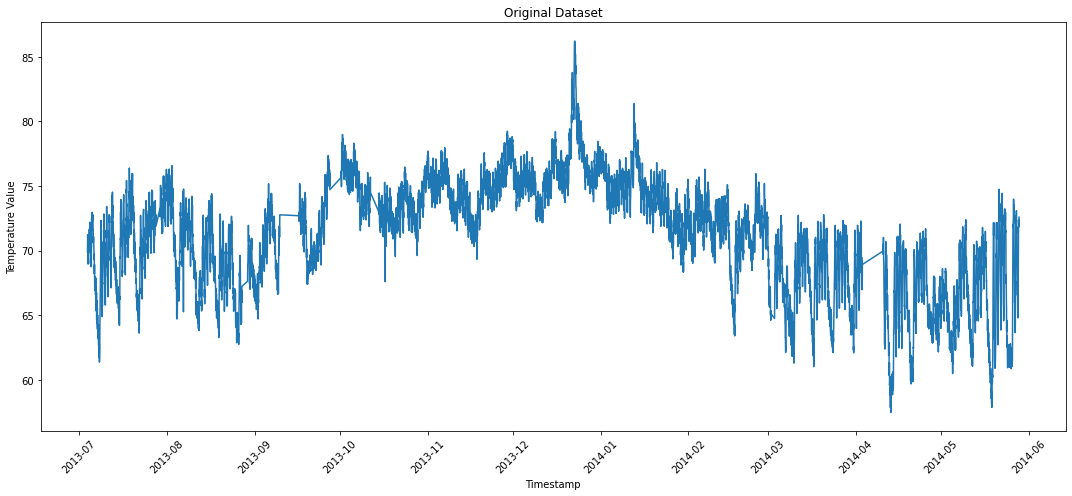

In [8]:
# Ensuring the date/time column is interpreted as datetime type
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Visualizing the original dataset
plt.figure(figsize=(15, 7))
plt.plot(data['timestamp'], data['value'])
plt.title('Original Dataset')
plt.xlabel('Timestamp')
plt.ylabel('Temperature Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Renaming the column 'value' to 'temperature'
data.rename(columns={'value':'temperature'}, inplace=True)
data

,timestamp,temperature
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


### TASK 2:
**Perform Feature Engineering on the dataset such that new features to be added. Specifically, you need to create a feature that will indicate the day of the week and time of the day. Namely, there should be four (4) categories (clusters?) for the feature, name it 'dtcat' (date-time-category): <br>
Weekday Day<br>
Weekday Night<br>
Weekend Day<br>
Weekend Night<br> Note: Some features such as ‘dayofweek’, ‘hours’, ‘day’, etc. may remain in the dataset.
We define the duration of ‘Day’ and Night’ as follows: Duration of 'Day' should be defined: 7:00am - 7:00pm Duration of 'Night' should be defined: 7:01pm - 6:59am <br>
Ultimately, we would like to figure out when (weekday, weekend, day or night) the device fails!**

In [10]:
# Extracting day of the week and hour from timestamp column to create new features

data['dayofweek'] = data['timestamp'].dt.dayofweek
data['hour'] = data['timestamp'].dt.hour

# Defining a function called get_dtcat to categorize each row
def get_dtcat(row):
    if row['dayofweek'] < 5:  # To check if it's a weekday 
        if 7 <= row['hour'] < 19:  # To check if it's day time
            return 'Weekday Day'
        else:
            return 'Weekday Night'
    else:  # else condition if it's a weekend
        if 7 <= row['hour'] < 19:  # To check if it's day time
            return 'Weekend Day'
        else:
            return 'Weekend Night'

        
# Applying the function to each row in order to create the 'dtcat' column       
data['dtcat'] = data.apply(get_dtcat, axis=1)


In [11]:
# Checking the new dataframe with the 'dtcat' feature 
data.head()

,timestamp,temperature,dayofweek,hour,dtcat
0,2013-07-04 00:00:00,69.880835,3,0,Weekday Night
1,2013-07-04 01:00:00,71.220227,3,1,Weekday Night
2,2013-07-04 02:00:00,70.877805,3,2,Weekday Night
3,2013-07-04 03:00:00,68.959400,3,3,Weekday Night
4,2013-07-04 04:00:00,69.283551,3,4,Weekday Night


### TASK 3:
**Apply the K-Means algorithm to the revised dataset and determine the best value for K by testing K in the range of [1, 20]. Plot a graph showing the number of clusters (K) in relation to score of each K-Means model.**

In [12]:
# Encoding the 'dtcat' categorical column as Kmeans doesn't handle categorical data directly
le = LabelEncoder()
data['dtcat_encoded'] = le.fit_transform(data['dtcat'])

# Standardizing the dataset 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['temperature', 'dayofweek', 'hour', 'dtcat_encoded']])

# Now applying K-Means and finding the best K value using the elbow method
scores = []  # sum of squared distances to the closest centroid for all observations in the cluster
k_range_values = range(1, 21)
for k in k_range_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(scaled_data)
    scores.append(kmeans.inertia_)


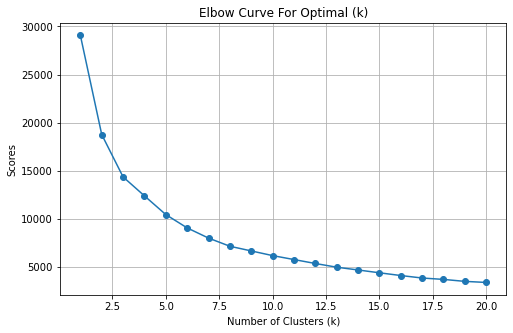

In [13]:
# Visualizing a graph to show the number of clusters k in relation to scores
plt.figure(figsize=(8, 5))
plt.plot(k_range_values, scores, marker='o')
plt.title('Elbow Curve For Optimal (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Scores')
plt.grid(True)
plt.show()

In [14]:
scaled_data

array([[-0.32058581,  0.00576899, -1.66153683, -0.05598894],
       [-0.00522828,  0.00576899, -1.51717197, -0.05598894],
       [-0.08585098,  0.00576899, -1.37280711, -0.05598894],
       ...,
       [ 0.18933168, -0.49933023,  0.21520635, -1.02936605],
       [ 0.13721779, -0.49933023,  0.35957121, -1.02936605],
       [ 0.31589058, -0.49933023,  0.50393607, -1.02936605]])

In [15]:
# Find the elbow point
kl = KneeLocator(range(1, 21), scores, curve="convex", direction="decreasing")

# Best K value is where the elbow is
best_k = kl.elbow

print(f"The optimal number of clusters is {best_k}")


The optimal number of clusters is 6


### TASK 4:
**After determining the best value of K, plot (scatter plot) all these K clusters by choosing 2 features from the dataset. Should the dataset has more than 2 features (which most likely will be the case), apply PCA to derive those 2 features (2 Principal Components) <br>[pca = PCA(n_components=2), then 'fit' pca into the dataset]**

C:\Users\PIYUSH GUPTA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


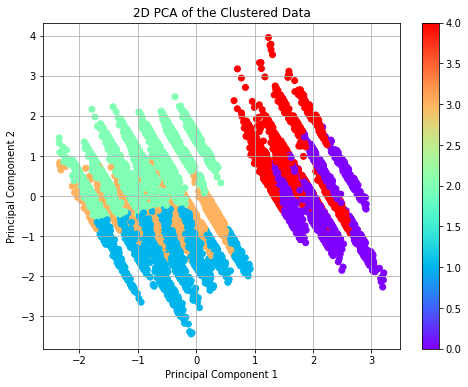

In [16]:
# After choosing the optimal K (let's assume it's 5 for illustration, derived from the Elbow curve)
best_k = 5

# Fit the KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(scaled_data)

# Assigning labels to each data point based on K-Means clustering
data['cluster_labels'] = kmeans.labels_

# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Creating a DataFrame with the principal components
new_data = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Adding the K-Means labels to the DataFrame
new_data['Cluster'] = kmeans.labels_

# Visualizing all the k clusters from 'PC1', 'PC2' using scatter plot
plt.figure(figsize=(8,6))
plt.scatter(new_data['PC1'], new_data['PC2'], c=new_data['Cluster'], cmap='rainbow')
plt.title('2D PCA of the Clustered Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.colorbar()
plt.show()


In [17]:
new_data

,PC1,PC2,Cluster
0,0.247072,-1.444848,3
1,0.149986,-1.145434,3
2,0.152911,-1.086179,3
3,0.249554,-1.251968,1
4,0.212841,-1.097528,1
...,...,...,...
7262,-1.100127,-0.140331,2
7263,-1.105835,-0.060345,2
7264,-1.115756,0.029759,2
7265,-1.120031,0.106305,2


### Outliers Fraction
**For outliers_fraction = 0.01 (1%), assume that someone gave us this figure - calculate outliers_fraction by finding the total number of outliers utilizing the IQR Method; specifically use the 1.5 x IQR rule**

In [18]:
# Defining function to calculate outliers using IQR method
def calculate_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outliers = ((data < Q1 - outlier_step) | (data > Q3 + outlier_step))
    return outliers

In [19]:
# Calculating outliers for the 'temperature' column
outliers = calculate_outliers_iqr(data['temperature'])

# Calculate outliers fraction
outliers_fraction_iqr = sum(outliers) / len(data)

print(f"Outliers fraction calculated by IQR method: {outliers_fraction_iqr:.3f}")

Outliers fraction calculated by IQR method: 0.005


### TASK 5:
**Apply the Gaussian distribution (EllipticEnvelope) algorithm, as defined at step 2. (Use this command: from sklearn.covariance import EllipticEnvelope) List anomalies (if any) in each category and show them graphically.**

In [20]:
# Defining function to fit EllipticEnvelope model and identify anomalies
def detect_anomalies(features, outliers_fraction_iqr):
    model = EllipticEnvelope(contamination=outliers_fraction_iqr)
    model.fit(features)
    predictions = model.predict(features)
    return predictions == -1  # -1 indicates anomalies/outliers

# Apply the model for outliers_fraction = 0.01 and outliers_fraction_iqr
for outliers_fraction in [0.01, outliers_fraction_iqr]:
    anomalies = detect_anomalies(scaled_data, outliers_fraction)
    data['anomalies'] = anomalies
    
    # Display anomalies in each category
    anomaly_counts = data.groupby('dtcat')['anomalies'].sum()
    print(f"\nAnomalies detected with outliers_fraction = {outliers_fraction:.3f}")
    print(anomaly_counts)



Anomalies detected with outliers_fraction = 0.010
dtcat
Weekday Day       0
Weekday Night     0
Weekend Day       0
Weekend Night    73
Name: anomalies, dtype: int64

Anomalies detected with outliers_fraction = 0.005
dtcat
Weekday Day       0
Weekday Night     0
Weekend Day       0
Weekend Night    35
Name: anomalies, dtype: int64


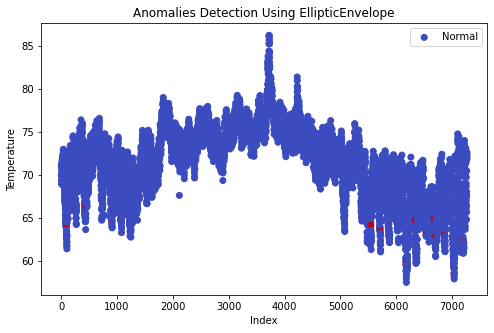

In [21]:
# Visualization of Anamolies
plt.figure(figsize=(8, 5))
plt.scatter(data.index, data['temperature'], c=data['anomalies'], cmap='coolwarm', label='Normal')
plt.title('Anomalies Detection Using EllipticEnvelope')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### TASK 6:
**Apply the Isolation Forest algorithm at each category, as defined step 2. (Use this command: from sklearn.ensemble import IsolationForest) List anomalies (if any) in each category and show them graphically.**

In [22]:
# Defining function to fit Isolation Forest model and identify anomalies as a boolean array
def detect_anomalies_isolation_forest(data, category, outliers_fraction_iqr):
    model = IsolationForest(contamination=outliers_fraction_iqr, random_state=0)
    features = data[data['dtcat'] == category][['temperature', 'dayofweek', 'hour', 'dtcat_encoded']]
    model.fit(features)
    predictions = model.predict(features)
    return predictions == -1

# Applying the Isolation Forest model for each category
categories = data['dtcat'].unique()
for category in categories:
    for outliers_fraction in [0.01, outliers_fraction_iqr]:
        data.loc[data['dtcat'] == category, 'anomalies'] = detect_anomalies_isolation_forest(data, category, outliers_fraction_iqr)
        
        # Display Anomalies
        print(f"\nAnomalies in category '{category}' with outliers_fraction = {outliers_fraction:.3f}")
        print(data[data['anomalies'] & (data['dtcat'] == category)])



Anomalies in category 'Weekday Night' with outliers_fraction = 0.010
               timestamp  temperature  dayofweek  hour          dtcat  \
3676 2013-12-20 23:00:00    79.091883          4    23  Weekday Night   
3725 2013-12-23 00:00:00    85.326165          0     0  Weekday Night   
3726 2013-12-23 01:00:00    85.705990          0     1  Weekday Night   
3727 2013-12-23 02:00:00    84.086971          0     2  Weekday Night   
3728 2013-12-23 03:00:00    85.222277          0     3  Weekday Night   
3730 2013-12-23 05:00:00    84.329000          0     5  Weekday Night   
3731 2013-12-23 06:00:00    83.118241          0     6  Weekday Night   
3748 2013-12-23 23:00:00    80.243625          0    23  Weekday Night   
6195 2014-04-14 00:00:00    58.832494          0     0  Weekday Night   
6363 2014-04-21 00:00:00    60.296951          0     0  Weekday Night   
7035 2014-05-19 00:00:00    58.423639          0     0  Weekday Night   
7036 2014-05-19 01:00:00    57.861906          0     1

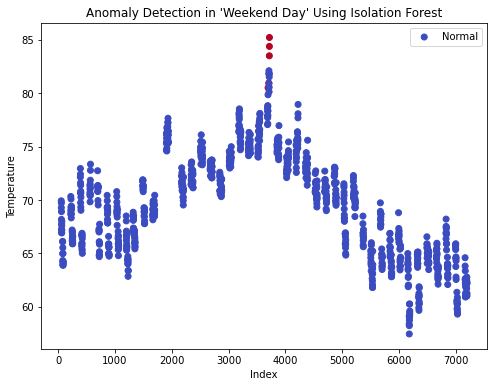

In [23]:
# Visualization of Anomalies
plt.figure(figsize=(8, 6))
plt.scatter(data[data['dtcat'] == category].index, data[data['dtcat'] == category]['temperature'], 
            c=data[data['dtcat'] == category]['anomalies'], cmap='coolwarm', label='Normal')
plt.title(f"Anomaly Detection in '{category}' Using Isolation Forest")
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.legend()
plt.show()


### TASK 7: Comparing both the models
**Which of the two (2) models performs better on detecting anomalies?**

In [24]:
# Fit and get predictions from Elliptic Envelope
ee_model = EllipticEnvelope(contamination=outliers_fraction_iqr)
ee_model.fit(scaled_data)
y_pred_ee = ee_model.predict(scaled_data)

# Fit and get predictions from Isolation Forest
if_model = IsolationForest(contamination=outliers_fraction_iqr)
if_model.fit(scaled_data)
y_pred_if = if_model.predict(scaled_data)


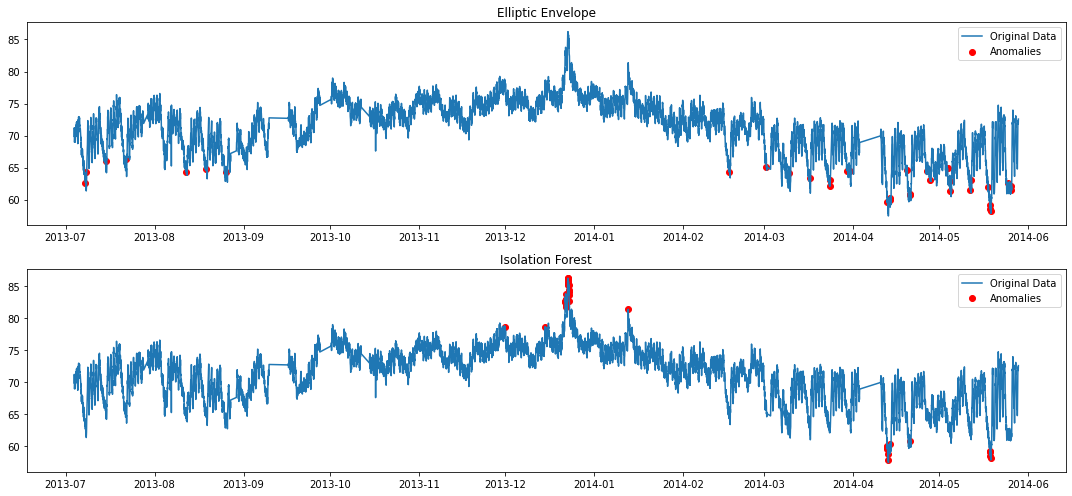

In [25]:
data['Elliptic_Envelope'] = y_pred_ee
data['Isolation_Forest'] = y_pred_if

plt.figure(figsize=(15, 7))

# Plot for Elliptic Envelope
plt.subplot(2, 1, 1)
plt.plot(data['timestamp'], data['temperature'], label='Original Data')
plt.scatter(data[data['Elliptic_Envelope']==-1]['timestamp'], 
            data[data['Elliptic_Envelope']==-1]['temperature'], 
            color='red', label='Anomalies')
plt.title('Elliptic Envelope')
plt.legend()

# Plot for Isolation Forest
plt.subplot(2, 1, 2)
plt.plot(data['timestamp'], data['temperature'], label='Original Data')
plt.scatter(data[data['Isolation_Forest']==-1]['timestamp'], 
            data[data['Isolation_Forest']==-1]['temperature'], 
            color='red', label='Anomalies')
plt.title('Isolation Forest')
plt.legend()

plt.tight_layout()
plt.show()


### Upon analysis of the two models—Elliptic Envelope and Isolation Forest—for anomaly detection, here are the observations:

### Elliptic Envelope:

This method detected a broader range of anomalies throughout the dataset.
Notably, there were multiple detections around 2013-11 to 2014-02.
The anomalies detected include both upward spikes and downward drops.
From a visual standpoint, this method seems to be more sensitive, capturing both minor and major potential anomalies.

### Isolation Forest:

This model detected fewer anomalies overall.
The main detections were around the end of the dataset, particularly in the period from 2014-03 to 2014-05.
These anomalies were primarily upward spikes in the data.
Visually, this model appears more conservative, highlighting only the most prominent deviations.

**To capture a comprehensive range of potential anomalies, including minor ones, the Elliptic Envelope may be preferable.**